# LC Ladder

In [ ]:
import jax
import jax.numpy as jnp
import diffrax
import time

from circulus.compiler import compile_netlist
from circulus.solvers.transient import VectorizedTransientSolver
from circulus.solvers.strategies import KLUSolver, DenseSolver
from circulus.netlist import draw_circuit_graph
from circulus.components import Resistor, Capacitor, Inductor, SmoothPulse, VoltageSourceAC

import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

In [6]:
def create_lc_ladder(n_sections):
    """
    Generates a netlist for an L-C transmission line.
    V_in -> R_source -> [L-C] -> [L-C] ... -> R_load -> GND
    """
    net = {
        "instances": {
            "GND": {"component": "ground"},
            "Vin": {"component": "voltage_source", "settings": {"V": 1.0, "delay": 2e-9, "tr":1E-11}}, # Step at 1ns
            #"Vin": {"component": "voltage_source", "settings": {"V": 1.0, "freq":FREQ}}, # Step at 1ns
            "Rs":  {"component": "resistor", "settings": {"R": R_SOURCE}}, 
            "Rl":  {"component": "resistor", "settings": {"R": R_LOAD}}, 
        },
        "connections": {}
    }

    # 1. Input Stage: GND -> Vin -> Rs -> Node_0
    net["connections"]["GND,p1"] = ("Vin,p2", "Rl,p2") # Ground input and load
    net["connections"]["Vin,p1"] = "Rs,p1"
    
    previous_node = "Rs,p2"

    # 2. Ladder Generation
    for i in range(n_sections):
        l_name = f"L_{i}"
        c_name = f"C_{i}"
        node_inter = f"n_{i}" # Node between L and C
        
        # Add Components
        # L=10nH, C=4pF -> Z0 = sqrt(L/C) = 50 Ohms. 
        # Delay per stage = sqrt(LC) = 200ps.
        net["instances"][l_name] = {"component": "inductor",  "settings": {"L": 10e-9}}
        net["instances"][c_name] = {"component": "capacitor", "settings": {"C": 4e-12}}

        # Connections
        # Prev -> L -> Inter -> C -> GND
        # Prev -> L -> Inter -> Next L...
        
        # Connect L: Previous Node -> Inter Node
        net["connections"][f"{l_name},p1"] = previous_node
        net["connections"][f"{l_name},p2"] = f"{c_name},p1" # Connect L to C
        
        # Connect C: Inter Node -> GND
        net["connections"]["GND,p1"] = (*net["connections"]["GND,p1"], f"{c_name},p2")

        # Advance
        previous_node = f"{l_name},p2" # The node after the inductor is the input to the next

    # 3. Termination
    net["connections"][f"Rl,p1"] = previous_node

    return net

In [7]:
N_SECTIONS = 50
USE_SPARSE = N_SECTIONS >= 50
T_MAX = 3*N_SECTIONS*0.5e-9
FREQ = 5.0/T_MAX
R_SOURCE = 50.0
R_LOAD = 50.0

Generating 50-stage LC Ladder...
Compilation finished in 0.0439s
System Matrix Size: 104x104 (10816 elements)
Solving DC Operating Point...
Running Transient Simulation...


100.00%|██████████| [00:00<00:00, 865.58%/s]


   ✅ Simulation Successful
Simulation completed in 2.5885s
Total Steps: 561


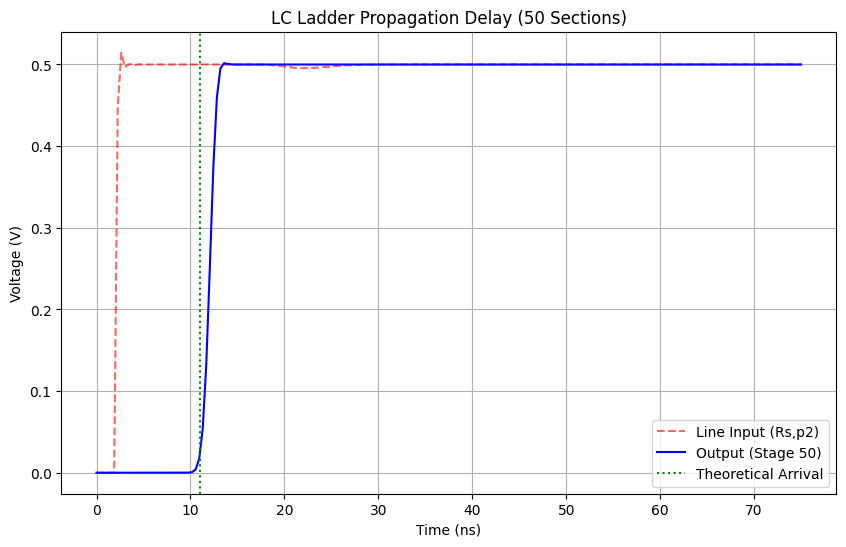

In [10]:

models_map ={
    'resistor': Resistor,
    'capacitor': Capacitor,
    'inductor': Inductor,
    'voltage_source': SmoothPulse,
    'ground': lambda: 0
}


print(f"Generating {N_SECTIONS}-stage LC Ladder...")
net_dict = create_lc_ladder(N_SECTIONS)

t0_compile = time.time()
groups, sys_size, port_map = compile_netlist(net_dict, models_map)
print(f"Compilation finished in {time.time() - t0_compile:.4f}s")
print(f"System Matrix Size: {sys_size}x{sys_size} ({sys_size**2} elements)")

if USE_SPARSE:
    linear_strat = KLUSolver.from_circuit(groups, sys_size, is_complex=False)
else:
    linear_strat = DenseSolver.from_circuit(groups, sys_size, is_complex=False)

print("Solving DC Operating Point...")
y0 = linear_strat.solve_dc(groups, jnp.zeros(sys_size))

solver_cls = VectorizedTransientSolver(linear_solver=linear_strat)

print("Running Transient Simulation...")

term = diffrax.ODETerm(lambda t, y, args: jnp.zeros_like(y))

step_controller = diffrax.PIDController(
    rtol=1e-3, 
    atol=1e-4, 
    pcoeff=0.2, 
    icoeff=0.5,
    dcoeff=0.0,
    force_dtmin=True,
    dtmin=1E-14,
    dtmax=1e-9,
    error_order=2
)

t0_sim = time.time()
sol = diffrax.diffeqsolve(
    term, solver_cls, 
    t0=0.0, t1=T_MAX, dt0=1e-11, 
    y0=y0, args=(groups, sys_size),
    stepsize_controller=step_controller,
    max_steps=1000000,
    saveat=diffrax.SaveAt(ts=jnp.linspace(0, T_MAX, 200)),
    progress_meter=diffrax.TqdmProgressMeter(refresh_steps=100) 
)

if sol.result == diffrax.RESULTS.successful:
    print("   ✅ Simulation Successful")

    t_end_sim = time.time()
    print(f"Simulation completed in {t_end_sim - t0_sim:.4f}s")
    print(f"Total Steps: {sol.stats['num_steps']}")

    node_out_idx = port_map["Rl,p1"]
    node_in_idx  = port_map["Rs,p2"]

    ts = sol.ts * 1e9
    v_in = sol.ys[:, node_in_idx]
    v_out = sol.ys[:, node_out_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(ts, v_in, 'r--', alpha=0.6, label='Line Input (Rs,p2)')
    plt.plot(ts, v_out, 'b-', linewidth=1.5, label=f'Output (Stage {N_SECTIONS})')
    
    plt.title(f"LC Ladder Propagation Delay ({N_SECTIONS} Sections)")
    plt.xlabel("Time (ns)")
    plt.ylabel("Voltage (V)")
    plt.legend(loc='upper left')
    plt.grid(True)
    
    theory_delay = N_SECTIONS * jnp.sqrt(10e-9 * 4e-12) * 1e9
    plt.axvline(theory_delay + 1.0, color='green', linestyle=':', label='Theoretical Arrival')
    plt.legend()
    
    plt.show()
else:
    print("   ❌ Simulation Failed")
    print(f"   Result Code: {sol.result}")